# E17 문자를 읽을 수 있는 딥러닝

<br>

## 다양한 OCR모델 비교하기

### 검증용 데이터셋 준비
- 짤들이 이미지에 적당한 글자가 섞여 있으므로 짤을 대상으로 10장을 준비함

### Google OCR API, keras-ocr, Tesseract로 테스트 진행
- 이미지 리스트를 정리한 후 반복문 실행하여 출력한 결과 모아 보기
- Google OCR API는 결제해야 하므로 생략

In [3]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [13]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

# 입력 이미지 경로를 지정해 주세요.
path =  '/home/aiffel0036/aiffel/ocr_python/test1.png'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)


- keras_ocr

In [14]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0036/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel0036/.keras-ocr/crnn_kurapan.h5


In [33]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
import glob
image_files = [file for file in glob.glob('/home/aiffel0036/aiffel/ocr_python/test*')]

images = [ keras_ocr.tools.read(files) for files in image_files]
prediction_groups = [pipeline.recognize([files]) for files in image_files]

- 테서렉트

In [47]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./sample.png', output_path='./output',j=1):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'

    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}_{j}.png")
            
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

#image_files = [file for file in glob.glob('/home/aiffel0036/aiffel/ocr_python/test*')]
#images = [ keras_ocr.tools.read(files) for files in image_files]
#prediction_groups = [pipeline.recognize([files]) for files in image_files]
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/output'
  #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 
cropped_image_path_list = []
for i in range(len(image_files)):
    cropped_image_path_list.append([file for file in crop_word_regions(image_files[i], 
                                                                       work_dir,i)])

In [153]:
def recognize_images(cropped_image_path_list,images):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    text_list = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text_list.append(recognized_data['text'])
    plt.imshow(images)
    plt.show()
    print(text_list)

### 테스트 결과 정리
- 시각화하기

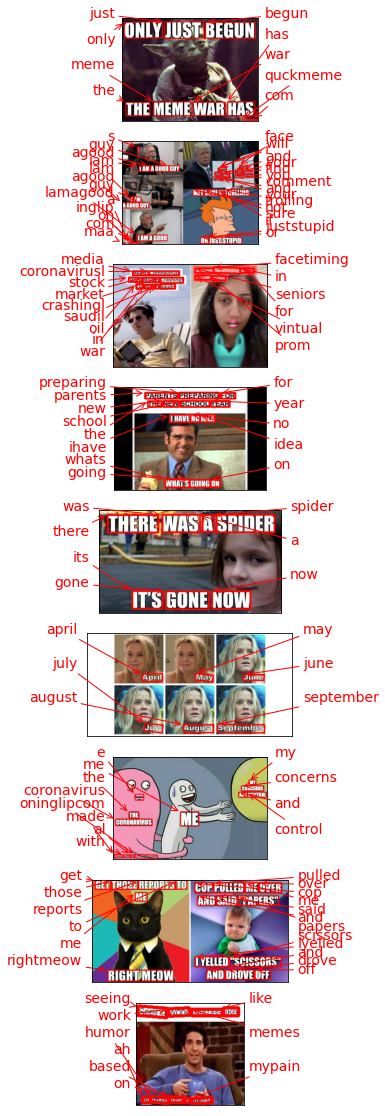

In [155]:
# keras
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

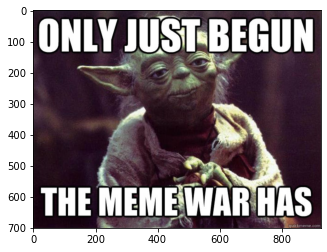

['ONLY\n\x0c', 'Pe\n\x0c', '\x0c', 'aS\n\x0c', 'a\n\x0c', 'fe\n\x0c', '-\n\x0c', 'THE\n\x0c', '\x0c', '\x0c']


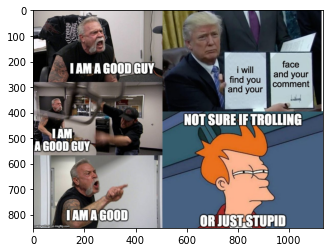

['\x0c']


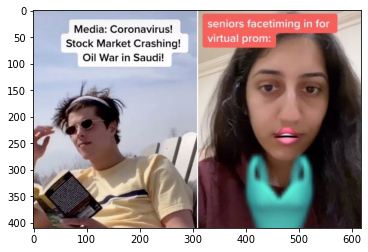

['Media’\n\x0c', 'Coronavirus!\n\x0c', 'Stock\n\x0c', 'Market\n\x0c', 'Crashing!\n\x0c', 'eri\n\x0c', 'Wa\n\x0c', 'rin\n\x0c', "Sauai'\n\x0c", '. a, £ b\n\x0c']


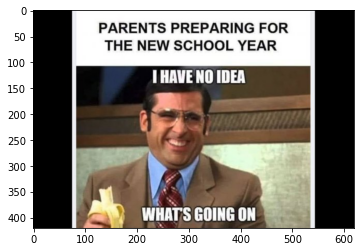

['PARENIS\n\x0c', 'PREPARING\n\x0c', 'FOR\n\x0c', 'THE\n\x0c', 'NEV\n\x0c', 'SCHOOL\n\x0c', 'YEAR\n\x0c', '=\n\x0c']


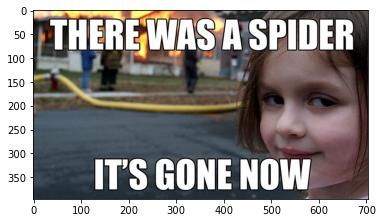

['eet i te\n\x0c', '[i\n\x0c', 'ask\n\x0c', 'Lt)\n\x0c', '\x0c', '_\n\x0c', 'a\n\x0c', '\x0c', 'a\n\x0c']


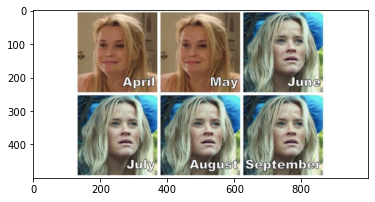

['| ( | / ) .\n\x0c']


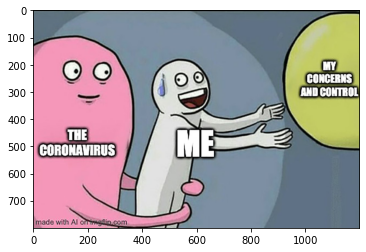

['rs | f ]\n\x0c']


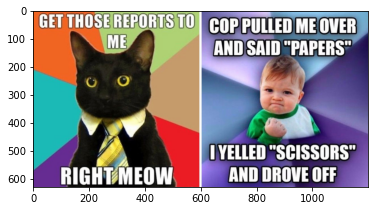

['GET yy a\n\x0c', 'Lae\n\x0c', 'GET\n\x0c', 'THOSE\n\x0c', 'REPORTS\n\x0c', '1)\n\x0c', '\x0c', '\x0c', 'fale\n\x0c', '"Tay\n\x0c', 'gh\n\x0c', 'i] 2\n\x0c', 'ANnS\n\x0c', 'wT\n\x0c', 'tit\n\x0c', 'VELLED\n\x0c', '"§\n\x0c', 'CISSORS |\n\x0c', 'Ay a\n\x0c', 'at\n\x0c']


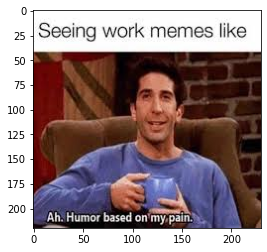

['1ehic\n\x0c', 'Ke\n\x0c', 'Seeing work n\n\x0c', '\x0c', 'we\n\x0c', 'sieuiied\n\x0c', '\x0c', 'mM Art\n\x0c']


[None, None, None, None, None, None, None, None, None]

In [156]:
# 테서렉트
[recognize_images(cropped_image_path_list[i],images[i]) for i in range(len(image_files))]

### 결과 분석과 결론 제시
- 구현하고자 하는 서비스의 목적과 내용
- OCR 모델들이 목적에 부합하는지 확인 위해 평가기준 제시
- 가장 나은 대안의 모델 선정

- Meme들에서 텍스트를 가장 잘 뽑아내는 것이 목적
- google api는 결제를 해야하므로 스킵
- keras는 비교적 추출이 잘 되나 한국어를 인식하지 못한다는 단점이 있음.
- 테서렉트는 이미지를 글자로 자주 인식하는 단점이 있으나 한국어 인식을 할 수 있음.
- 정확하게 뽑아내는 것이 목적이므로 keras가 적절